In [ ]:
import pandas as _hex_pandas
import datetime as _hex_datetime
import json as _hex_json

In [ ]:
hex_scheduled = _hex_json.loads("false")

In [ ]:
hex_user_email = _hex_json.loads("\"example-user@example.com\"")

In [ ]:
hex_run_context = _hex_json.loads("\"logic\"")

In [ ]:
hex_timezone = _hex_json.loads("\"UTC\"")

In [ ]:
hex_project_id = _hex_json.loads("\"8a897f9f-9a20-4187-af68-c4109b682605\"")

In [ ]:
hex_project_name = _hex_json.loads("\"FuzzyTrees Project\"")

In [ ]:
hex_status = _hex_json.loads("\"\"")

In [ ]:
hex_categories = _hex_json.loads("[]")

In [ ]:
hex_color_palette = _hex_json.loads("[\"#4C78A8\",\"#F58518\",\"#E45756\",\"#72B7B2\",\"#54A24B\",\"#EECA3B\",\"#B279A2\",\"#FF9DA6\",\"#9D755D\",\"#BAB0AC\"]")

In [ ]:
run_on_seeds = _hex_json.loads("false")

In [ ]:
train_random_forest = _hex_json.loads("true")

In [ ]:
table_1 = None

In [ ]:
table_2 = None

<img src="/api/v1/file/d16ad416-04b0-4dc8-bc1d-446b07be6521" width="900" height="200"  />

FuzzyTrees is a machine-learning application built in Python and Hex that combines fuzzy-matching techniques with a random forest classifier to do approximate matches on records from separate tables/data sources. In the original use case, this was to find duplicate vet practice records that were flowing in through DBT from vso and vss data sources all the way into practice_online_details in the core layer. Duplicate records within our infrastructure can compromise the integrity of downstream reporting and analytics, which is why it's important to develop tools/strategies to avoid and handle duplicates.

For all pairs of records in two tables, FuzzyTrees computes similarity metrics on shared fields (name, city, address, zip) using the <a href='https://en.wikipedia.org/wiki/Levenshtein_distance'>Levenshtein distance</a> and <a href='https://en.wikipedia.org/wiki/Jaro%E2%80%93Winkler_distance'>Jaro-Winkler distance</a>. These similarity metrics are 
used for feature engineering for the random forest classifier algorithm. Scanning over duplicate VSS practices, FuzzyTrees finds the best approximate match in the table of VSO practices--providing a base mapping for systematic deduplication. 

In [ ]:
# if train_random_forest:
!pip install jellyfish
import jellyfish as j

1. load dataset, 5000 matched vso/vss practices, 5000 unmatched practices. DONE
2. Clean data (lower case everything, regexp non-alphanumerics) DONE
3. Implement levenshtein and jaro winkler distances. DONE
4. generate 8 point feature vector of similarity metrics for all pairs (5 Levenshtein, 5 Jaro Winkler) DONE
5. train test split, train random forest classifier on 6000 pairs (3000 match, 3000 no-match), validation on 1000 points (500 match, 500 no-match), test on 1000 pairs (500 match, 500 no-match). 
6. adjust hyperparams, etc. if necessary 
7. report evaluation metrics 
8. Algorithm for finding fuzzy-matches across vss / vso practices.
8. front end, and communication 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
from sklearn.datasets import load_iris
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
import fuzzywuzzy as f
from fuzzywuzzy import fuzz
from joblib import dump, load


In [ ]:

if train_random_forest:
    og_pairs = pd.read_csv("training_data_zips.csv")
    pair_data = og_pairs
    pair_data.head()

In [ ]:
# convert all strings to lower case and remove spaces and commas. 
if train_random_forest:
    pair_data.loc[:, pair_data.dtypes == 'object'] = pair_data.select_dtypes(['object']).apply(lambda x: x.str.lower())
    pair_data.loc[:, pair_data.dtypes == 'object'] = pair_data.select_dtypes(['object']).apply(lambda x: x.str.replace('[ ,-]', '', regex=True))
    pair_data.loc[:, pair_data.dtypes == 'object'] = pair_data.select_dtypes(['object']).apply(lambda x: x.str.replace('[&]', 'and', regex=True))
    pair_data['og_idx'] = pair_data.index
    pair_data = pair_data.sample(frac=1).reset_index(drop=True)
    pair_data.head()
# pair_data = pair_data.iloc[1:10,:]

In [ ]:
def jaro_winkler_distance(str1,str2):
    score = j.jaro_winkler_similarity(str1,str2)
    return score

def levenshtein_distance(str1,str2):
    score = f.fuzz.ratio(str1, str2)/100
    return score

In [ ]:

def generate_feature_vectors(columns_features,pair_data,distance_function):
    for jj in range(len(columns_features)):
        print("Creating feature vector for: " + columns_features[jj])
        distances = np.zeros((len(pair_data),1))
        for ii in range(len(pair_data)):
            distance = distance_function(str(pair_data.iloc[ii,jj+1]),str(pair_data.iloc[ii,jj+6]))
            distances[ii] = (distance)
        pair_data[columns_features[jj]] = distances
    return pair_data



if train_random_forest:

    lev_features = ['name_lev_dist','city_lev_dist','address_lev_dist','zip_lev_dist'] 
    jaro_features = ['name_jaro_dist','city_jaro_dist','address_jaro_dist','zip_jaro_dist']
    pair_data = generate_feature_vectors(lev_features,pair_data,levenshtein_distance)
    pair_data = generate_feature_vectors(jaro_features,pair_data,jaro_winkler_distance)
    pair_data['TOTAL_SCORE'] = pair_data.iloc[:,-8:].sum(axis=1)

Creating feature vector for: name_lev_dist
Creating feature vector for: city_lev_dist
Creating feature vector for: address_lev_dist
Creating feature vector for: zip_lev_dist
Creating feature vector for: name_jaro_dist
Creating feature vector for: city_jaro_dist
Creating feature vector for: address_jaro_dist
Creating feature vector for: zip_jaro_dist


In [ ]:
lev_features = ['name_lev_dist','city_lev_dist','address_lev_dist','zip_lev_dist'] 
jaro_features = ['name_jaro_dist','city_jaro_dist','address_jaro_dist','zip_jaro_dist']


example = pd.read_csv("example.csv")

example = generate_feature_vectors(lev_features,example,levenshtein_distance)
example = generate_feature_vectors(jaro_features,example,jaro_winkler_distance)
example['TOTAL_SCORE'] = example.iloc[:,-8:].sum(axis=1)



Creating feature vector for: name_lev_dist
Creating feature vector for: city_lev_dist
Creating feature vector for: address_lev_dist
Creating feature vector for: zip_lev_dist
Creating feature vector for: name_jaro_dist
Creating feature vector for: city_jaro_dist
Creating feature vector for: address_jaro_dist
Creating feature vector for: zip_jaro_dist


In [ ]:
example

,vss_odu_id,vss_name,vss_address,vss_city,vss_zip,vso_odu_id,vso_name,vso_address,vso_city,vso_zip,name_lev_dist,city_lev_dist,address_lev_dist,zip_lev_dist,name_jaro_dist,city_jaro_dist,address_jaro_dist,zip_jaro_dist,TOTAL_SCORE
0,13685,Ridgemoor Animal Hospital,Palm Harbor,4936 Ridgemoor Blvd,34685,101711,Ridgemoor Animal Hospital,Palm Harbor,4936 Ridgemoor Blvd,34685,1.0,1.0,1.00,1.0,1.000000,1.0,1.000000,1.000000,8.000000
1,31203,Veterans Memorial Drive Animal Hospital,Houston,12315 Veterans Memorial Drive,77014,108861,Sun City Animal Hospital,SUN CITY,10026 SANTA FE DR,85351,0.6,0.0,0.26,0.2,0.632051,0.0,0.519946,0.466667,2.678664


Here is an example, the first row here is a matched pair of VSO and VSS practices. Scroll to the right on the table, you can see the engineered similatiy features, taking the Levenshtein and Jaro-Winkler-similarity measures (known as distances) with the name, city, address, and zip fields from the VSO and VSS practices, respectively. We take these 'fuzzy' similarity measures because we can't do an exact matching process for these records since the fields aren't exactly identical (one VSS practice may spell their address with "St.", the VSO practice spelling that same duplicated practice with "Street" instead). The specific distances have slightly different use cases--Jaro-Winkler is best for name matching, and texts with similar prefixes. Levenshtein is good for short texts, and for spelling corrections/typos. 

These features tell us how similar the given fields are across the VSO and VSS data soures. We can observe that across the board for the first row, the name, city, address, and zipcodes between VSO and VSS data sources match perfectly, and so they obtain distance scores of 1. On the other hand, with the second row, the VSO and VSS practices do not match, and the similarity scores are much less than 1 across the board. 

We cast the practice matching task as a binary classification problem, the algorithm should output 1 if the practices match, and 0 otherwise. The random forest classifier is a state of the art ML algorithm that averages a bunch of decision trees generated on subsamples of the data to determine this binary classification. In this sense, it determines how important each of these features are for the classification of a 'match'. For instance, it's okay if the addresses have slight differences (St. vs Street, etc.), but the zipcode should be a perfect match.

We used a dataset of ~3000 matching pairs of practices (verified manually) and ~3000 non-matching pairs of practices to train FuzzyTrees. 

The validation set consists of ~1000 matching pairs of practices and ~1000 non-matching pairs of practices, it serves as a basis to understand the baseline generalizability of the model past the training data, and for tuning hyperparameters to improve performance--before testing predictions on the actual test set.

The test set consists of ~1000 matching pairs of practices and ~1000 non-matching pairs of practices. The test set is used to evaluate the model's performance after it has been trained and validated. The key characteristic of the test set is that it is only used once, at the very end of the model development process, to provide an unbiased evaluation of the final model's performance. It simulates how the model would perform on unseen data in a real-world scenario.

<!-- On the test set, FuzzyTrees achieves strong performance with the below accuracy, precision, and recall scores.  -->

In [ ]:
pair_data

,vss_odu_id,vss_name,vss_address,vss_city,vss_zip,vso_odu_id,vso_name,vso_address,vso_city,vso_zip,...,og_idx,name_lev_dist,city_lev_dist,address_lev_dist,zip_lev_dist,name_jaro_dist,city_jaro_dist,address_jaro_dist,zip_jaro_dist,TOTAL_SCORE
0,153598,banderacountyveterinaryclinic,pobox1647,medina,78055,112200,spayneutercharlotte,2017ndavidsonst,medina,78055,...,119985,0.42,0.17,1.00,1.00,0.613349,0.451852,1.000000,1.000000,5.655201
1,169043,mypetsvet(kennesaw),840ernestwbarrettpkwynw,kennesaw,30144,109686,sanfranciscoanimalclinic,3003sw107ave,miami,33165,...,91634,0.23,0.29,0.15,0.40,0.423830,0.411353,0.000000,0.600000,2.505183
2,111842,bluepearlkentuckylouisville,13160magisterialdr,louisville,40223,175892,healthypetaltoona,1515mayerroad,altoona,54720,...,20034,0.32,0.52,0.24,0.40,0.486202,0.693732,0.495238,0.600000,3.755172
3,178673,petvet365clermont,1670ehighway50suitee,clermont,34711,175950,lowcountryvetsatmayriver,245gibbetrdunitb,clermont,34711,...,116706,0.29,0.22,1.00,1.00,0.568627,0.447222,1.000000,1.000000,5.525850
4,107487,kindnessanimalhospital,20lindenst,waltham,2452,103910,cedarridgeanimalhospital,184charlottehwy,waltham,28803,...,104815,0.74,0.16,1.00,0.22,0.728981,0.388889,1.000000,0.483333,4.721203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
127585,125456,eurekaveterinaryclinicllc,180smainst,eureka,89316,147551,southsideanimalhospitaldnu,6045scentralave,phoenix,85042,...,26140,0.31,0.32,0.15,0.20,0.508291,0.544444,0.436508,0.466667,2.935910
127586,109291,foresthillanimalhospital,3133foresthillirenerd#102,germantown,38138,108621,skycrestanimalclinic,5301illinois83,longgrove,60047,...,65108,0.50,0.36,0.32,0.00,0.602350,0.604762,0.531481,0.000000,2.918594
127587,122021,madisonveterinaryhospital,1260durhamrd,madison,6443,104467,banfieldpethospitaloffortcollins,4432scollegeave,madison,6443,...,125377,0.42,0.15,1.00,1.00,0.661776,0.433333,1.000000,1.000000,5.665110
127588,120080,northcountyanimalhospital,109s65thaveste106,ridgefield,98642,122543,countrysideanimalhospital,13219eadamsrd,hammond,70403,...,16432,0.80,0.27,0.12,0.20,0.766349,0.492911,0.414286,0.466667,3.530213


In [ ]:
if train_random_forest:
    columns_features = ['og_idx','name_lev_dist','city_lev_dist','address_lev_dist','zip_lev_dist','name_jaro_dist','city_jaro_dist','address_jaro_dist','zip_jaro_dist','TOTAL_SCORE']
    feature_df = pair_data.loc[:,columns_features]
    target_df = pair_data.loc[:,'is_match']

    X = np.array(feature_df.iloc[:,1:])  # Features
    y = np.array(target_df)  # Target variable

    # First, split the data into training + validation set and test set
    X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

    # Now, split the training + validation set into training and validation sets
    X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1)
    
    # Initialize the Random Forest classifier
    random_forest_classifier = RandomForestClassifier(n_estimators=200, random_state=1)

    # Fit the model on the training data
    random_forest_classifier.fit(X_train, y_train)

    # Predict the labels of the test set
    y_pred = random_forest_classifier.predict(X_val)
    y_pred_test = random_forest_classifier.predict(X_test)

    # # Calculate the accuracy of the model
    # accuracy = accuracy_score(y_test, y_pred)
    # print(f"Model Accuracy: {accuracy*100:.5f}%")

In [ ]:
import plotly.graph_objects as go


In [ ]:
y_test.sum()

1148

In [ ]:
if train_random_forest:
    # Accuracy
    accuracy = accuracy_score(y_val, y_pred)
    print(f'Validation Set Accuracy: {accuracy:.5f}')

    # Precision
    precision = precision_score(y_val, y_pred)
    print(f'Validation Set Precision: {precision:.5f}')

    # Recall
    recall = recall_score(y_val, y_pred)
    print(f'Validation Set Recall: {recall:.5f}')

    # F1 Score
    f1 = f1_score(y_val, y_pred)
    print(f'Validation Set F1 Score: {f1:.5f}')

    # ROC-AUC
    roc_auc = roc_auc_score(y_val, y_pred)
    print(f'Validation Set ROC-AUC: {roc_auc:.5f}')

    # Confusion Matrix
    cm = confusion_matrix(y_val, y_pred)
    print('Validation Set Confusion Matrix:')
    print(cm)

    # Optionally, plot ROC curve
    import matplotlib.pyplot as plt

    fpr, tpr, _ = roc_curve(y_val, y_pred)
    roc_auc = auc(fpr, tpr)

    fig = go.Figure()

    # Plot ROC curve
    fig.add_trace(go.Scatter(x=fpr, y=tpr,
                        mode='lines',
                        name=f'ROC curve (area = {roc_auc:.5f})',
                        line=dict(color='darkorange', width=2)))

    # Plot diagonal line
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
                        mode='lines',
                        name='Random Guessing',
                        line=dict(color='navy', width=2, dash='dash')))

    # Set layout
    fig.update_layout(
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        title='Validation Set ROC',
        xaxis=dict(range=[0, 1]),
        yaxis=dict(range=[0, 1.05]),
        legend=dict(x=0.02, y=0.98),
    )

    fig.show()
    
    # Accuracy
    accuracy = accuracy_score(y_test, y_pred_test)
    print(f'Test Set Accuracy: {accuracy:.5f}')

    # Precision
    precision = precision_score(y_test, y_pred_test)
    print(f'Test Set Precision: {precision:.5f}')

    # Recall
    recall = recall_score(y_test, y_pred_test)
    print(f'Test Set Recall: {recall:.5f}')

    # F1 Score
    f1 = f1_score(y_test, y_pred_test)
    print(f'Test Set F1 Score: {f1:.5f}')

    # ROC-AUC
    roc_auc = roc_auc_score(y_test, y_pred_test)
    print(f'Test Set ROC-AUC: {roc_auc:.5f}')

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_test)
    print('Test Set Confusion Matrix:')
    print(cm)

    fpr, tpr, _ = roc_curve(y_test, y_pred_test)
    roc_auc = auc(fpr, tpr)


    fig = go.Figure()

    # Plot ROC curve
    fig.add_trace(go.Scatter(x=fpr, y=tpr,
                        mode='lines',
                        name=f'ROC curve (area = {roc_auc:.5f})',
                        line=dict(color='darkorange', width=2)))

    # Plot diagonal line
    fig.add_trace(go.Scatter(x=[0, 1], y=[0, 1],
                        mode='lines',
                        name='Random Guessing',
                        line=dict(color='navy', width=2, dash='dash')))

    # Set layout
    fig.update_layout(
        xaxis_title='False Positive Rate',
        yaxis_title='True Positive Rate',
        title='Test Set ROC',
        xaxis=dict(range=[0, 1]),
        yaxis=dict(range=[0, 1.05]),
        legend=dict(x=0.02, y=0.98),
    )

    fig.show()


Validation Set Accuracy: 0.99996
Validation Set Precision: 0.99910
Validation Set Recall: 1.00000
Validation Set F1 Score: 0.99955
Validation Set ROC-AUC: 0.99998
Validation Set Confusion Matrix:
[[24408     1]
 [    0  1109]]


Test Set Accuracy: 0.99996
Test Set Precision: 1.00000
Test Set Recall: 0.99913
Test Set F1 Score: 0.99956
Test Set ROC-AUC: 0.99956
Test Set Confusion Matrix:
[[24370     0]
 [    1  1147]]


#### Are these metrics too good to be true?

- While fuzzy-matching tasks are difficult in general--the data is not excessively noisy here--and the differences between fields often reflect point edits, capitalization differences, and alternative spelling. 

The random forest algorithm is very well-suited to this dataset and task, particularly when we give it two robust fuzzy-measures of string similarity on the fields as features. Very high performance metrics can be expected in this case, and are necessary in order to ensure exhaustive and correct de-duplication. That being said, the validation and test sets are defined using the same VSO/VSS practice-matching use case, and a futher exploration would be to apply FuzzyTrees to a different matching use case and see how the performance generalizes.

#### What exactly are these evaluation metrics and plots above? 


### Accuracy
- **What it measures:** The proportion of all matches that the model got right.
- **How to calculate:** It's the number of correct predictions divided by the total number of predictions.
- **Use case:** Good for an overall sense of how often the model is correct, but can be misleading if the classes are imbalanced (e.g., 95% of the data is of one class).

### Precision
- **What it measures:** The proportion of positive classifications that were actually correct.
- **How to calculate:** It's the number of true matches divided by the total number of positive predictions (true positives + false positives).
- **Use case:** Useful when the cost of a false positive is high. For example, in email spam detection, you'd want to be really sure an email is spam before filtering it out. 

### Recall (Sensitivity)
- **What it measures:** The proportion of actual positive matches that were identified correctly.
- **How to calculate:** It's the number of true positive predictions divided by the total number of actual positives (true positives + false negatives).
- **Use case:** Important when the cost of a false negative is high. For example, in disease screening, you wouldn’t want to miss diagnosing a person with the disease. In our case, we need to make sure we aren't missing any matching practices because then we won't be able to de-duplicate them from practice_online_details! 

### F1-Score
- **What it measures:** The balance between precision and recall.
- **How to calculate:** It's the harmonic mean of precision and recall, giving both metrics equal weight. Calculated as 2 * (precision * recall) / (precision + recall).
- **Use case:** Useful when you need a balance between precision and recall and there’s an uneven class distribution. It’s more informative than accuracy in cases of imbalanced classes.

### ROC (Receiver Operating Characteristic) Score and AUC (Area Under the ROC Curve)
- **What they measure:** The ROC curve plots the true positive rate (recall) against the false positive rate for different classification thresholds. The AUC (Area Under the Curve) measures the entire two-dimensional area underneath the ROC curve from (0,0) to (1,1).
- **How to calculate:** The ROC score is not a single number but a plot. The AUC can be calculated based on the plot, with a value of 1 representing a perfect model and a value of 0.5 representing a model that does no better than random chance.
- **Use case:** Very useful for evaluating the performance of a binary classifier, especially in cases of imbalanced datasets. It gives an idea of how well the model is able to distinguish between classes.


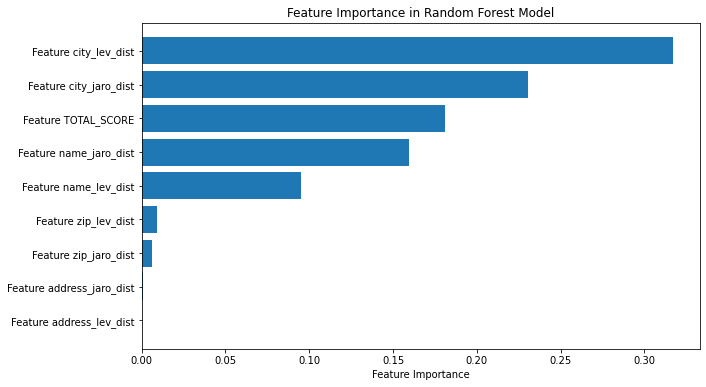

In [ ]:

if train_random_forest:
    # Get the feature importances
    feature_importances = random_forest_classifier.feature_importances_

    # Optionally, you can sort the features by importance
    sorted_idx = feature_importances.argsort()

    # Plotting the feature importances
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(sorted_idx)), feature_importances[sorted_idx], align='center')
    plt.yticks(range(len(sorted_idx)), [f"Feature {feature_df.columns[i+1]}" for i in sorted_idx])
    plt.xlabel("Feature Importance")
    plt.title("Feature Importance in Random Forest Model")
    plt.show()


### What is this feature importance plot?

A feature importance plot is a visual representation used in machine learning to show the relative importance or contribution of each feature to the model's predictions. This plot helps to identify which features (variables or inputs) are most influential in determining the outcome of the random forest classifier. It shows that zip code under the Levenshtein distance is the most important feature for determining the classification, as expected--then name and zip under Jaro distance.

Understanding Influence: It shows which features have the most impact on the model's predictions. This can be crucial for understanding the underlying dynamics of the model, especially in complex models where the decision-making process is not inherently transparent.

Simplification and Focus: By identifying the most important features, you can potentially simplify the model by removing features that contribute little to no predictive power, making the model faster and more efficient without significantly compromising accuracy.

In [ ]:
# pair_data.head()

In [ ]:

if run_on_seeds:
    print("Running on all practices..")
    df_vso = pd.read_csv("vso_unmatched.csv")
    df_vss = pd.read_csv("vss_unmatched.csv")
    gt_matches = pd.read_csv("ground_truth_matches.csv")


    total_vso_ids = len(df_vso)
    match_table = pd.DataFrame(np.zeros((7000,11)),columns=['vss_odu_id', 'vss_name', 'vss_address', 'vss_city', 'vss_zip', 'vso_odu_id', 'vso_name', 'vso_address', 'vso_city', 'vso_zip','total_score'])
    table_idx = 0
    # for ii in range(22,len(df_vss)):

    for ii in range(22,24):
        print(ii)
        tmp_vss_df = df_vss.iloc[ii,:]
        # Repeat the row N times
        duplicates = pd.concat([tmp_vss_df]*total_vso_ids, axis=1).transpose()
        # Append duplicates to the original DataFrame
        tmp_vss_df = pd.concat([duplicates], ignore_index=True)
        tmp_merged_df = pd.concat([tmp_vss_df,df_vso],axis=1)

        lev_features = ['name_lev_dist','city_lev_dist','address_lev_dist','zip_lev_dist'] 
        jaro_features = ['name_jaro_dist','city_jaro_dist','address_jaro_dist','zip_jaro_dist']
        tmp_merged_df = generate_feature_vectors(lev_features,tmp_merged_df,levenshtein_distance)
        tmp_merged_df = generate_feature_vectors(jaro_features,tmp_merged_df,jaro_winkler_distance)
        columns_features = ['name_lev_dist','city_lev_dist','address_lev_dist','zip_lev_dist','name_jaro_dist','city_jaro_dist','address_jaro_dist','zip_jaro_dist']
        tmp_merged_df['TOTAL_SCORE'] = tmp_merged_df.loc[:,columns_features].sum(axis=1)
        columns_features  = ['name_lev_dist','city_lev_dist','address_lev_dist','zip_lev_dist','name_jaro_dist','city_jaro_dist','address_jaro_dist','zip_jaro_dist','TOTAL_SCORE']
        feature_df = tmp_merged_df.loc[:,columns_features]
        X = np.array(feature_df)  # Features

        y_pred = random_forest_classifier.predict(X)

        indices = np.where(y_pred == 1)[0]
        if len(indices) != 0:
            tmp_df2 = tmp_merged_df.loc[indices,columns_features]
            tmp_df2['summed'] = tmp_df2.sum(axis=1)
            max_index = tmp_df2['summed'].idxmax()

            match_table.iloc[table_idx,0:10] = tmp_merged_df.iloc[int(max_index),0:10]
            match_table.iloc[table_idx,10] = tmp_merged_df.loc[int(max_index),'TOTAL_SCORE']
            table_idx += 1    
        else:
            pass    

    match_table
    match_table.to_csv("match_outputs.csv")

In [ ]:
# match_table
# Save your model to a file
dump(random_forest_classifier, 'random_forest_model.joblib')

['random_forest_model.joblib']

In [ ]:
# Load the model from the file
# clf = load('random_forest_model.joblib')

In [ ]:
random_forest_classifier

RandomForestClassifier(n_estimators=200, random_state=1) In a Jupyter environment, please rerun this cell to show the HTML representation or trust the notebook. On GitHub, the HTML representation is unable to render, please try loading this page with nbviewer.org. RandomForestClassifier RandomForestClassifier(n_estimators=200, random_state=1)